In [6]:
import pandas as pd
import math

#Read the data in
df = pd.read_csv('backward_all.csv')

In [7]:
#Convert to negative weeks to death, so numbers are in chronological order
df = df.sort_values(by='weeks_to_death', ascending=False)

In [8]:
#df.head()

In [9]:
#Select albumin average for FEMALES in FMC_EUROPE
# Get subset of the dataframe to sonify
alb = df.loc[(df['database'] == 'FMC_EUROPE') & (df['MALE'] == 0), 'albumin_avg']

#take 5 week rolling average, then normalize the values
alb = alb.rolling(5).mean()[5:]
alb = (alb - alb.min())/(alb.max() - alb.min())

In [10]:
# Config
BPM = 120 # Beats per minute, e.g. 60, 75, 100, 120, 150
DIVISIONS_PER_BEAT = 4 # e.g. 4 = quarter notes, 8 = eighth notes
VARIANCE_MS = 20 # +/- milliseconds an instrument note should be off by to give it a little more "natural" feel
VARIANCE_RATE = 0 # for adding variance to the playback rate
INSTRUMENTS_INPUT_FILE = 'data/instruments.csv'

REPORT_SUMMARY_OUTPUT_FILE = 'data/report_summary.csv'
REPORT_SEQUENCE_OUTPUT_FILE = 'data/report_sequence.csv'
INSTRUMENTS_OUTPUT_FILE = 'data/ck_instruments.csv'
SEQUENCE_OUTPUT_FILE = 'data/ck_sequence.csv'

INSTRUMENTS_DIR = 'instruments/'

BEAT_MS = round(60.0 / BPM * 1000)
ROUND_TO_NEAREST = round(BEAT_MS/DIVISIONS_PER_BEAT)

In [11]:
#For getting pseudo-random numbers
def halton(index, base):
    result = 0.0
    f = 1.0 / base
    i = 1.0 * index
    while(i > 0):
        result += f * (i % base)  
        i = math.floor(i / base)
        f = f / base
    return result

#Round n to the nearest nearest
def roundToNearest(n, nearest):
    return 1.0 * round(1.0*n/nearest) * nearest

In [12]:
# Make sure there's no sudden drop in gain
def continueFromPrevious(instrument):
	return instrument['Bracket Min'] > 0 or instrument['Bracket Max'] < 100

# Multiplier based on sine curve
def getMultiplier(percent_complete):
	radians = percent_complete * math.pi
	multiplier = math.sin(radians)
	if multiplier < 0:
		multiplier = 0.0
	elif multiplier > 1:
		multplier = 1.0
	return multiplier

# Retrieve gain based on current beat
def getGain(instrument, beat):
	beats_per_phase = instrument['Gain Phase']
	percent_complete = float(beat % beats_per_phase) / beats_per_phase
	multiplier = getMultiplier(percent_complete)
	from_gain = instrument['From Gain']
	to_gain = instrument['To Gain']
	min_gain = min(from_gain, to_gain)
	gain = multiplier * (to_gain - from_gain) + from_gain
	gain = max(min_gain, round(gain, 2))
	return gain

# Get beat duration in ms based on current point in time
def getBeatMs(instrument, beat, round_to):	
	from_beat_ms = instrument['From Beat MS']
	to_beat_ms = instrument['To Beat MS']
	beats_per_phase = instrument['Tempo Phase']
	percent_complete = float(beat % beats_per_phase) / beats_per_phase
	multiplier = getMultiplier(percent_complete)
	ms = multiplier * (to_beat_ms - from_beat_ms) + from_beat_ms
	ms = int(roundToNearest(ms, round_to))
	return ms

# Return if the instrument should be played in the given interval
def isValidInterval(instrument, elapsed_ms):
	interval_ms = instrument['Interval MS']
	interval = instrument['Interval']
	interval_offset = instrument['Interval Offset']	
	return int(math.floor(1.0*elapsed_ms/interval_ms)) % interval == interval_offset

In [13]:
#Read in instruments data, do some preprocessing (based on Foo's code)
instruments = pd.read_table(INSTRUMENTS_INPUT_FILE)
instruments['Type'] = instruments['Type'].str.lower().str.replace(' ','_')
instruments['File'] = INSTRUMENTS_DIR + instruments['File']
instruments['From Beat MS'] = round(BEAT_MS/instruments['From Tempo'])
instruments['To Beat MS'] = round(BEAT_MS/instruments['To Tempo'])
instruments['Interval MS'] = instruments['Interval Phase']*BEAT_MS

In [14]:
# Add beats to sequence
def addBeatsToSequence(instrument, duration, ms, beat_ms, round_to):
	global sequence
	global hindex
	offset_ms = int(instrument['Tempo Offset'] * beat_ms)
	ms += offset_ms
	previous_ms = int(ms)
	from_beat_ms = instrument['From Beat MS']
	to_beat_ms = instrument['To Beat MS']
	min_ms = min(from_beat_ms, to_beat_ms)
	remaining_duration = int(duration)
	elapsed_duration = offset_ms
	continue_from_prev = continueFromPrevious(instrument)
	while remaining_duration >= min_ms:
		elapsed_ms = int(ms)
		elapsed_beat = int((elapsed_ms-previous_ms) / beat_ms)
		# continue beat from previous
		if continue_from_prev:
			elapsed_beat = int(elapsed_ms / beat_ms)
		this_beat_ms = getBeatMs(instrument, elapsed_beat, round_to)
		# add to sequence if in valid interval
		if isValidInterval(instrument, elapsed_ms):
			h = halton(hindex, 3)
			variance = int(h * VARIANCE_MS * 2 - VARIANCE_MS)
			rate_variance = float(h * VARIANCE_RATE * 2 - VARIANCE_RATE)
			sequence.append({
				'instrument_index': instrument['index'],
				'instrument': instrument,
				'position': 0,
				'gain': getGain(instrument, elapsed_beat),
				'rate': 1.0 + rate_variance,
				'elapsed_ms': max([elapsed_ms + variance, 0])
			})
			hindex += 1
		remaining_duration -= this_beat_ms
		elapsed_duration += this_beat_ms
		ms += this_beat_ms

In [15]:
#Get number of instruments
n_instruments = instruments.shape[0]

#Amount of time, in MS, to spend on each data point
week_duration = 1000

sequence = []
hindex = 0

#Loop through each instrument
for index, instrument in enumerate(instruments.iterrows()):
    #ms is our current place in the song
    ms = 0
    #queue_duration is how long to play the instrument for current 'period' (accumulation of weeks)
    queue_duration = 0
    
    instrument = instrument[1]
    instrument['index'] = index
    #Loop through each week's value
    for week_val in alb:
        #Should this instrument be playing for this week?
        play_instrument = (week_val*n_instruments) > index
        if play_instrument:
            #add this week's duration to queue_duration, since instrument should play for this week
            queue_duration += week_duration        
        elif queue_duration > 0:
            #We've stopped playing the instrument, add the queued beats to sequence and increment where we are in the song
            addBeatsToSequence(instrument, queue_duration, ms, BEAT_MS, ROUND_TO_NEAREST)
            ms += queue_duration + week_duration
            queue_duration = 0
        else:
            #Not playing the instrument and weren't before this week, just skip this week
            ms += week_duration
    if queue_duration > 0:
        #If we ended the song playing this instrument, make sure we add the residual queue time to the sequence
        addBeatsToSequence(instrument, queue_duration, ms, BEAT_MS, ROUND_TO_NEAREST)
    

In [16]:
# Sort sequence so beats happen in chronological order
sequence = sorted(sequence, key=lambda k: k['elapsed_ms'])

# Add milliseconds to sequence
elapsed = 0
for index, step in enumerate(sequence):
	sequence[index]['milliseconds'] = step['elapsed_ms'] - elapsed
	elapsed = step['elapsed_ms']


In [17]:
import csv
import os 

# Write instruments to file
with open(INSTRUMENTS_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)	
    for index, instrument in enumerate(instruments.iterrows()):
        w.writerow([index])
        w.writerow([instrument[1]['File']])
    #f.seek(-2, os.SEEK_END) # remove newline
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote instruments to file: '+INSTRUMENTS_OUTPUT_FILE)

# Write sequence to file
with open(SEQUENCE_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)	
    for step in sequence:
        w.writerow([step['instrument_index']])
        w.writerow([step['position']])
        w.writerow([step['gain']])
        w.writerow([step['rate']])
        w.writerow([step['milliseconds']])
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote sequence to file: '+SEQUENCE_OUTPUT_FILE)


Successfully wrote instruments to file: data/ck_instruments.csv
Successfully wrote sequence to file: data/ck_sequence.csv


In [18]:
instrument

(82, Name                               Subway Horn
 Type                                      wind
 Price                                      400
 Bracket Min                                  0
 Bracket Max                                100
 File               instruments/subway_horn.wav
 From Gain                                  0.1
 To Gain                                    0.3
 From Tempo                               0.125
 To Tempo                                 0.125
 Gain Phase                                  24
 Tempo Phase                                  8
 Tempo Offset                                 0
 Interval Phase                              16
 Interval                                     1
 Interval Offset                              0
 Active                                       1
 From Beat MS                              4000
 To Beat MS                                4000
 Interval MS                               8000
 Name: 82, dtype: object)

In [19]:
alb

305    0.930851
304    0.940918
303    0.949097
302    0.939148
301    0.966043
300    0.986222
299    0.970106
298    0.953105
297    0.972404
296    0.983059
295    0.959559
294    0.944436
293    0.967308
292    0.979624
291    0.979757
290    0.967600
289    0.994974
288    1.000000
287    0.989459
286    0.956288
285    0.967570
284    0.944313
283    0.933969
282    0.912249
281    0.920883
280    0.926215
279    0.927441
278    0.914839
277    0.944545
276    0.945203
         ...   
236    0.687168
235    0.669950
234    0.668284
233    0.651719
232    0.634451
231    0.626484
230    0.618834
229    0.631016
228    0.618567
227    0.624700
226    0.626435
225    0.619012
224    0.586983
223    0.586058
222    0.597638
221    0.556589
220    0.541274
219    0.523378
218    0.507939
217    0.467202
216    0.442872
215    0.386063
214    0.358250
213    0.314127
212    0.270014
211    0.242388
210    0.214717
209    0.167931
208    0.108068
207    0.000000
Name: albumin_avg, Lengt

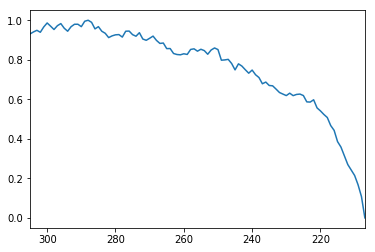

In [20]:
import matplotlib.pyplot as plt

alb.plot()
plt.show()

In [21]:
df.loc['albumin_avg'].plot()
plt.show()

KeyError: 'the label [albumin_avg] is not in the [index]'

In [ ]:
df

In [ ]:
instruments